In [1]:
import os
import time
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
# 读取训练数据和测试数据
train = pd.read_csv("happiness_train_complete.csv", encoding='latin-1')
submit = pd.read_csv("happiness_test_complete.csv", encoding='latin-1')

# 将缺失值替换为 -8
train.fillna(value=-8, inplace=True)
submit.fillna(value=-8, inplace=True)

# 显示替换后的数据框的前几行
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,...,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,...,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,...,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,...,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,...,2,50,50,50,50,50.0,50,50,50,50


C:\Users\ishine\AppData\Local\Temp\ipykernel_18688\4215541911.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, k] = X_date[i]
C:\Users\ishine\AppData\Local\Temp\ipykernel_18688\4215541911.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, k] = X_date[i]
C:\Users\ishine\AppData\Local\Temp\ipykernel_18688\4215541911.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

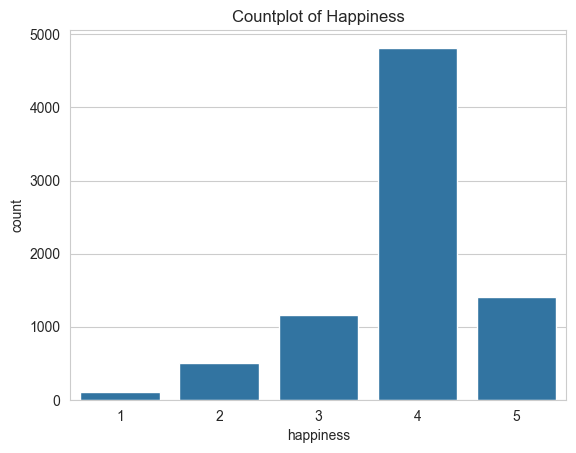

In [3]:
from matplotlib import pyplot as plt

train.reset_index(inplace=True)
X_train = train.loc[train['happiness'] > 0]
y = X_train['happiness']

def date_format(dt):
    t_year = int(dt.split(" ")[0].split("/")[0])
    t_mon = int(dt.split(" ")[0].split("/")[1])
    t_mday = int(dt.split(" ")[0].split("/")[2])
    t_hour = int(dt.split(" ")[1].split(":")[0])
    t_min = int(dt.split(" ")[1].split(":")[1])
    return (t_year,t_mon,t_mday,t_hour,t_min)
X_date = train['survey_time']
X_date = X_date.apply(lambda x: pd.Series(date_format(x)))

title = ['t_year','t_mon','t_mday','t_hour','t_min']
for i, k in enumerate(title):
    X_train.loc[:, k] = X_date[i]
#    删除无效信息
X_train = X_train.drop(["id","index","happiness","survey_time","edu_other","property_other","invest_other"], axis=1)

# 假设 'happiness' 是你的目标变量列
sns.countplot(x=y, data=X_train)
plt.title('Countplot of Happiness')
plt.show()


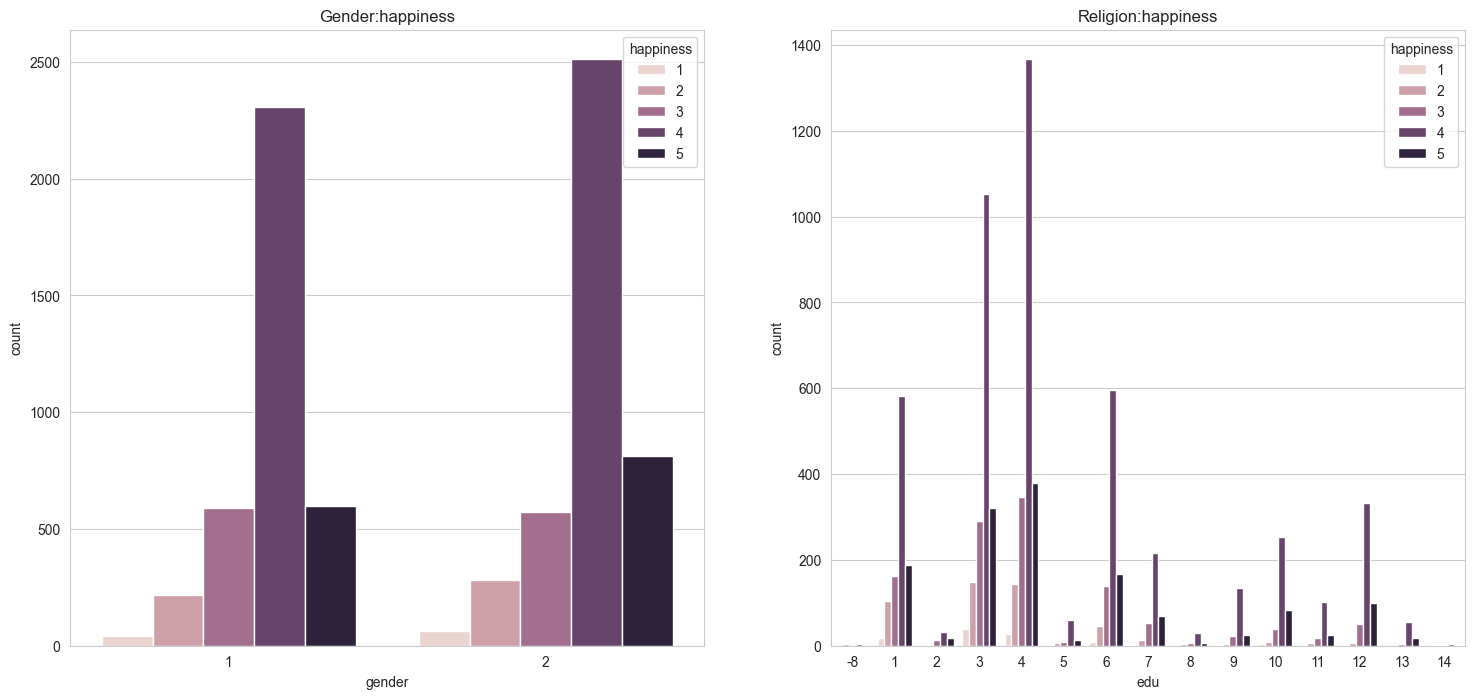

In [4]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 探究性别和幸福感的分布
sns.countplot(x='gender', hue=y, data=X_train, ax=ax[0])
ax[0].set_title('Gender:happiness')

# 探究宗教和幸福感的分布
sns.countplot(x='edu', hue=y, data=X_train, ax=ax[1])
ax[1].set_title('Religion:happiness')

plt.show()


In [5]:
submit.reset_index(inplace=True)
X_submit = submit
X_date = X_submit['survey_time']
X_date = X_date.apply(lambda x: pd.Series(date_format(x)))

for i,k in enumerate(title):
    X_submit.loc[:, k] = X_date[i]
out = X_submit[["id"]]
X_submit = X_submit.drop(["id","index","survey_time","edu_other","property_other","invest_other"],axis=1)

In [6]:
import pandas as pd

# 合并 X_train 和 y_train
data_combined = pd.concat([X_train, y], axis=1)

# 计算所有变量与 'happiness' 之间的相关性系数
correlation_with_target = data_combined.corr()['happiness'][abs(data_combined.corr()['happiness'])>0.05]

# 输出相关性系数
print("Correlation with target variable ('happiness'):")
correlation_with_target


Correlation with target variable ('happiness'):


edu                 0.103048
edu_yr              0.073307
political           0.080986
join_party          0.080424
property_8         -0.051929
                      ...   
public_service_6    0.162514
public_service_7    0.154029
public_service_8    0.128678
public_service_9    0.129723
happiness           1.000000
Name: happiness, Length: 66, dtype: float64

C:\Users\ishine\AppData\Local\Temp\ipykernel_18688\3496887552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_combined.corr()['happiness'].values, y=data_combined.corr()['happiness'].index, orient='h', palette='viridis')


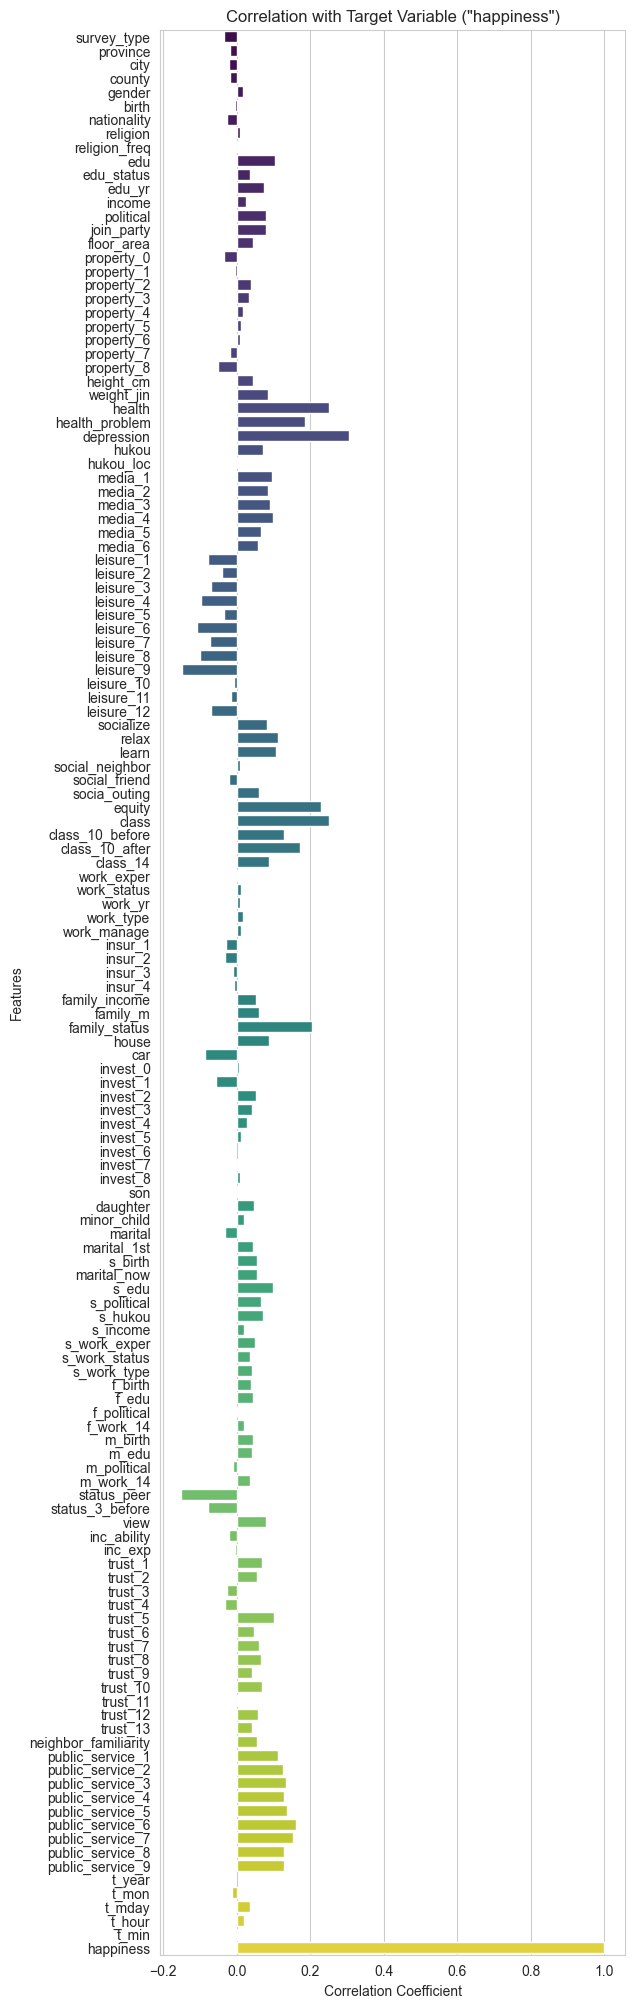

In [7]:
# 可视化相关性
plt.figure(figsize=(6, 25))
sns.barplot(x=data_combined.corr()['happiness'].values, y=data_combined.corr()['happiness'].index, orient='h', palette='viridis')
plt.title('Correlation with Target Variable ("happiness")')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [8]:
features = (data_combined.corr()['happiness'][abs(data_combined.corr()['happiness'])>0.05]).index
features = features.values.tolist()
features.extend(['Age', 'work_exper'])
features.remove('happiness')
len(features)

67

<Axes: xlabel='Age', ylabel='count'>

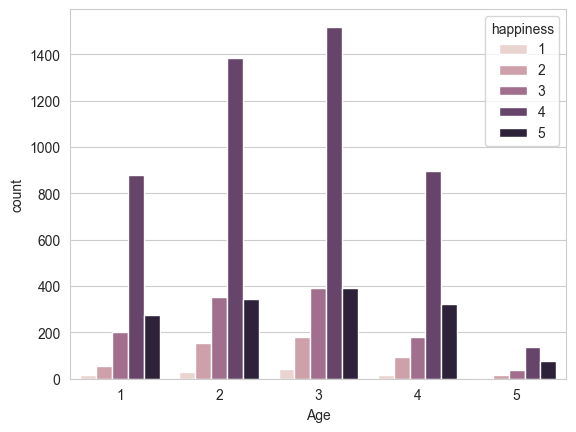

In [9]:
# 一般会将年龄分箱，避免噪声和异常值的影响
combine=[X_train,X_submit]

for dataset in combine:
    dataset.loc[:, 'Age'] = dataset.loc[:, 't_year'] - dataset.loc[:, 'birth']
    dataset.loc[dataset['Age'] <= 16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 80, 'Age'] = 5
sns.countplot(x='Age', hue=y, data=X_train)

In [10]:
X_train = X_train[features]
X_submit = X_submit[features]

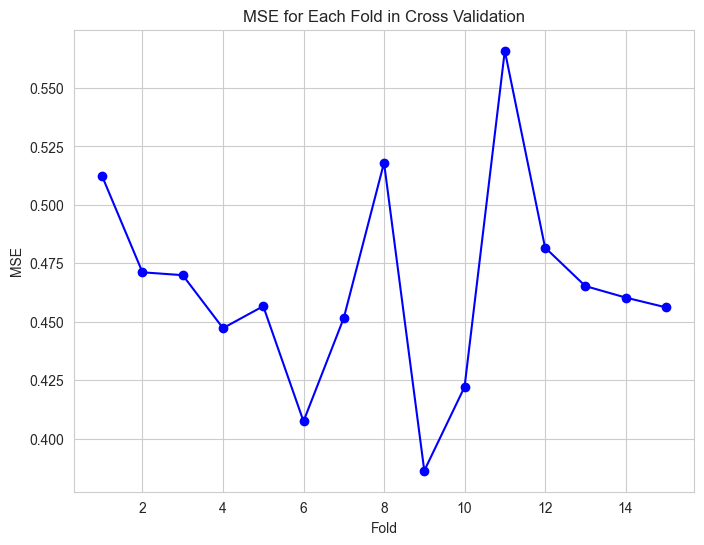

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 重新导入需要的库
import joblib
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 定义模型参数
model_params = {
    'n_jobs': -1,
    'learning_rate': 0.051,
    'n_estimators': 400,
    'num_leaves': 11,
    'reg_alpha': 2.0,
    'reg_lambda': 2.1,
    'min_child_samples': 6,
    'min_split_gain': 0.5,
    'colsample_bytree': 0.2,
    'verbosity': -1
}

# 初始化模型
model = LGBMRegressor(**model_params)

# 定义 KFold
kfold = KFold(n_splits=15, shuffle=True, random_state=12)

# 数据准备
X = X_train
Y = y

# 存储每个折的 MSE
mse_values = []

# 循环交叉验证
for i, (train, test) in enumerate(kfold.split(X)):
    X_train_fold = X.iloc[train]
    y_train_fold = Y.iloc[train]
    X_test_fold = X.iloc[test]
    y_test_fold = Y.iloc[test]
    # 训练模型
    model.fit(X_train_fold, y_train_fold)
    # 预测
    y_pred_fold = model.predict(X=X_test_fold)
    # 计算 MSE
    mse_fold = mean_squared_error(y_true=y_test_fold, y_pred=y_pred_fold)
    # 存储 MSE
    mse_values.append(mse_fold)
    # 保存模型
    joblib.dump(filename=f"light_{i}.joblib", value=model)

# 绘制 MSE 图
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE for Each Fold in Cross Validation')
plt.show()


In [12]:
print(np.mean(mse_values))

0.46481567959513165


In [13]:
# test = test.sample(frac=1,replace=False,random_state=12)
# 更新排序
# 将原来为空的数据填入平均值
prediction = model.predict(X_submit)
out["happiness"] = np.array(prediction)
out.to_csv("happiness_submit.csv",index=False)
print("done")

done


C:\Users\ishine\AppData\Local\Temp\ipykernel_18688\1325346704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out["happiness"] = np.array(prediction)
